<a href="https://colab.research.google.com/github/gekoramy/uni.deep-learning/blob/final-report/238746_240074.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Assignment 2023
## From words to bounding boxes: exploring visual grounding using CLIP

|     #    |                 |                                 @ |
|:--------:|-----------------|----------------------------------:|
| `238746` | Luca Mosetti    | luca.mosetti-1@studenti.unitn.it  |
| `240074` | Stefano Genetti | stefano.genetti@studenti.unitn.it |


In [ ]:
%%shell
if ! [ -d assets ]; then
  gdown -q 1WTQNojr6KvWbzowuqfBDj5z4CYd03eeQ &&
  tar --warning=no-unknown-keyword -xf assets.tar &&
  rm assets.tar
fi

## Abstract

Visual grounding involves linking language and perception by grounding linguistic symbols in the visual world. More in depth, in this work we face the problem usually referred to by the literature as *Referring expression comprehension* (REC). In this context the overall goal is to localize a target object in an image described by a referring expression phrased in natural language. In order to accomplish this challenging task we rely on the CLIP (*Contrastive Language-Image Pre-training*) [2] pre-trained model as a starting point for transfer learning. The capabilities of this foundation model pose a starting point to design a joint embedding approach to solve the problem at hand. In this report we provide an overview of the strategies which we have adopted in order to fine-tune CLIP for the task under discussion. We have evaluated our proposed models on the commonly used RefCOCOg dataset [3]. In addition to this, our contribution is to provide three useful instances of the dataset filled with the bounding boxes proposed by some well known  object detection algorithms. As further explained in the following of this report this solution allows to considerably speed up the training procedure. We conveniently  provide these datasets together with the code to generate them at the following GitHub repository: todo: link-repo. Furthermore, in the present notebook we alternate the text cells with code cells incorporating the implemented code.

## Introduction

Language and vision are closely related in daily life. We naturally use verbal descriptions in our conversations to refer to the objects in a given scene. Although such an activity is straightforward for the human being, the task of referring expression comprehension remains challenging for a software agent which has to bridge computer vision and natural language processing in order to achieve a comprehensive understanding of complex language semantics and various types of visual information. The problem has been receiving increasing attention from both academia and industry due to its great potential in vision-and-language navigation [1] and natural human-computer interaction. The aim of our work is to train a model which takes as input an image and a natural language prompt and outputs a single bounding box which corresponds to the entity referred to in the textual description (Figure 1).

Formula input -> output
\begin{equation}
    f: I \times P \rightarrow B
\end{equation}

According to the literature, the most common methods to tackle the task at hand are based on the encoding of image regions and expressions into the same vector space [4]. To this end we adopt the CLIP (Contrastive Language-Image Pre-training) [2] model as a foundation model for our framework. This strategy allows us to take advantage of a powerful model pre-trained with massive computational resources and consequently reduce the amount of power that we need to obtain meaningful results. Clearly, visual grounding is not the original purpose of CLIP. Consequently, we need to perform transfer learning in order to fine-tune the original model to build a customized one that excels in our downstream task. In this paper we provide a detailed overview of the solutions that we have studied to solve the problem. To this end we have trained and evaluated several model architectures according to the metrics commonly suggested by the literature, on the RefCOCOg dataset [3], a variant of the Referring Expression Generation (REG) dataset, which is particularly suitable in our case. For each implemented model we report the obtained performances bringing to light its strengths and weaknesses. A methodological comparison of the proposed architecture designs has allowed us to select the most promising implementation. As outlined at the end of this document, the final model has been further refined in an attempt to improve its generalization capabilities. The overall goal of this work is not to achieve state of the art performances. Rather, our contribution is to suggest original solutions to tackle the problem and highlight promising directions which should be further investigated with stronger hardware capabilities. In this regard, throughout the report we strain our attention on several valuable strategies which have been adopted in order to deal with limited time and computational resources. The notebook is organized as follows.
*   At the beginning we provide a brief overview of the related works proposed by the literature over the years to face similar challenges.
*   Then, we explain the peculiarities of our reference dataset. There is no predefined dataset class appropriate for the visual grounding task. Hence, we describe how we create our custom dataset classes to load and read the available data collection correctly and appropriately.
* In Section nn we describe the metrics which we have adopted in order to evaluate and compare the implemented solutions.
* In the subsequent section we describe our training free baseline algorithm which has represented a convenient starting point for our project.
* In the following sections we comment on the architectures that we have designed on top of the observations and experience progressively maturated. First of all we illustrate in Section nn the object detection algorithms which have been examined in order to maximize the quality of the proposed bounding boxes to be evaluated.
* In Section nn we describe our first fine-tuned architecture. In this first implementation we focus on a standard fine-tuning approach.
* Subsequently, inspired by the work of Sachin Goyal et al. [5] we have tried to fine-tune our model following the same training procedure employed by CLIP.
* In Section nn we propose an original technique to exploit the self-attention mechanism in order to produce contextualized latent space representations of visual and textual prompts.
* This pipeline allowed us to identify the most auspicious model among the ones considered. In Section nn we present our solutions to further improve its generalization capabilities.
* At the end, we conclude the report with some final considerations and valuable suggestions to inspire further research on the field.     

In between the textual descriptions of our findings we conveniently provide our implemented code. Everything has been written in Python programming language and specifically with the PyTorch machine learning framework. We strain our attention to be as clear as possible with our lines of code. To this end we have carefully annotated the data types which should make the overall implementation more comprehensible for the reader. To achieve this we have used Python [typing](https://docs.python.org/3/library/typing.html) and [Pydantic](https://docs.pydantic.dev/latest/). Furthermore, we have sometimes utilized the [doctest](https://docs.python.org/3/library/doctest.html) module to verify that the implemented functions behave exactly as shown.


**Figure 1**

On the left the input of our problem. On the right a bounding box is drawn around the most interesting portion of the image according to the description. As clarified in the following, sometimes in our dataset there are provided more than a single description for a given bounding box. In this case we profitably take advantage of the multiple prompts available trying to achieve better predictions.  

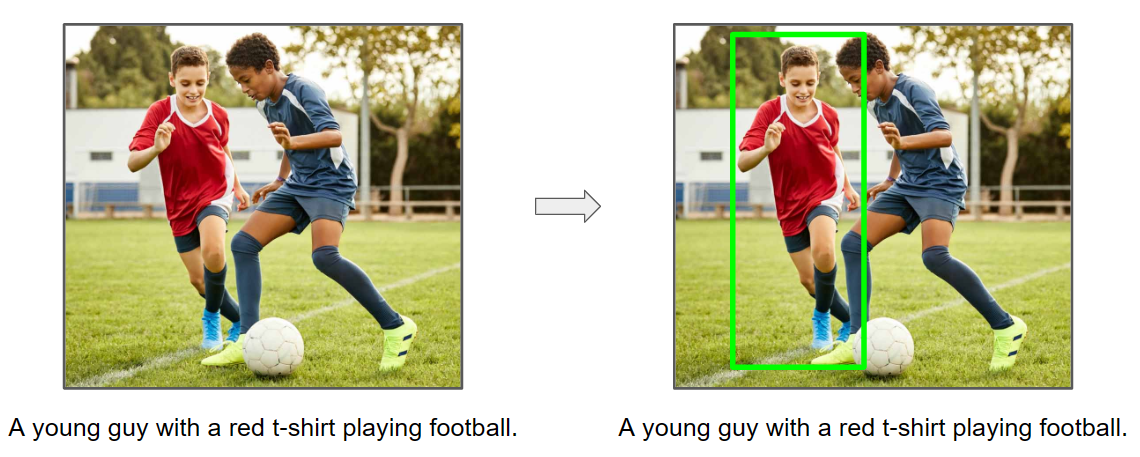

todo: forse dire che usiam Resnet 50 version of clip

## Hardware

In this section we briefly mention the hardware infrastructures that we have used to execute our experiments, train the proposed neural networks and evaluate our models. Throughout the project we have strained our attention to carefully plan our executions in order to deal with limited resources and to invest the computational time at our disposal as fruitfully as possible.

The whole project has been written with the environment provided by the free of charge version of Google Colab. The platform allows to execute the code with only the CPU or with Nvidia T4 GPUs. Unfortunately, the execution on GPU is subject to strict and very limited time constraints. Consequently, we use the CPU mainly to verify that the implemented code works as intended and for debugging. Once the overall architecture behaves correctly, we perform short time tests with small dataset subsets on GPU with the aim of understanding whether the model is learning something and how its performance could be refined.

In addition to this we had at our disposal 50 hours of execution on the very powerful GPUs Tesla V100 provided by Microsoft Azure. The performance evaluations presented in this report have been computed on models trained on this hardware for a reasonable amount of time.


In [ ]:
%load_ext tensorboard

In [ ]:
%%shell
tee requirements.txt << END
ftfy
jaxtyping
jupyter
matplotlib
optuna
pandas
pydantic
regex
tensorboard
torch
torchinfo
torchvision
tqdm
END

pip install -q -r requirements.txt
pip install -q git+https://github.com/openai/CLIP.git

In [ ]:
import csv
import doctest
import itertools as it
import math
import os
import typing as t
import random

import clip
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import torch
import torch.nn as nn

from collections import defaultdict
from jaxtyping import Float, UInt, Int
from pydantic.dataclasses import dataclass
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from torchvision.io import read_image, ImageReadMode
from torchvision.ops import box_iou, box_convert
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    Normalize,
    InterpolationMode,
    ConvertImageDtype,
    ColorJitter,
    GaussianBlur,
    RandomChoice,
    RandomInvert,
    RandomPosterize,
    RandomSolarize,
    RandomAdjustSharpness,
    RandomAutocontrast,
    RandomEqualize,
    Grayscale,
)
from torchvision.transforms.functional import crop
from tqdm.auto import tqdm, trange
from optuna.study import Study
from optuna.visualization import (
    plot_contour,
    plot_edf,
    plot_intermediate_values,
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances,
    plot_rank,
    plot_slice,
    plot_timeline,
)
from optuna.storages import RDBStorage

In [ ]:
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [ ]:
T = t.TypeVar("T")
K = t.TypeVar("K")
V = t.TypeVar("V")


def groupby(
    xs: list[T],
    map_key: t.Callable[[T], K],
    map_value: t.Callable[[T], V] = lambda x: x,
) -> dict[K, list[V]]:
    return {
        k: [map_value(v) for v in vs]
        for k, vs in it.groupby(sorted(xs, key=map_key), key=map_key)
    }



## Related work

To the best of our knowledge it is not obvious to understand whether our task falls into the realm of Referring Expression Comprehension or Visual Grounding problem. Actually the two categories are very similar. According to the exhaustive survey of Yanyuan Quiao, Chaorui Deng and Qi Wu [4], visual grounding is to localize multiple object regions in an image corresponding to multiple noun phrases from a sentence that describes the underlying scene. While the goal of referring expression comprehension is to find the best matching region by the given expression.
More broadly, referring expression is normally associated with three tasks: generation, segmentation and comprehension.
* Referring expression generation (REG) aims at generating a discriminative description of an object in an image, which is very similar to the image captioning task. Different from general image captions, referring expressions are more specific about an object or region in the image [4].
* Referring expression segmentation (RES) aims to segment the referenced objects according to the referring expression [6].
* Referring expression comprehension (REC) is the reverse task of REG, which aims at localizing objects in an image based on natural language descriptions. The REC problem is typically formulated as selecting the best region from a set of region proposals extracted from the image.

Furthermore, even Object Detection resembles our objectives. However, although this latter uses predefined category labels to classify fixed objects, in our project we focus on natural language expressions to refer to objects. These phrases are more practical because they vary according to the content of images and texts, so they are more suitable for real application scenarios. Succeeding in this task is of crucial importance for other vision and language problems, such as Visual Question Answering [7][8] and Visual dialogue [9][10]. Though they have diverse model architectures, they necessitate a prior localization of the objects corresponding to a given language description or question. Notably, since the textual information is not a separate label, a simple detection method cannot meet the requirements.

More in depth, the methods to face this problem proposed by the literature over the years are divided into seven categories: joint embedding approaches, modular-based approaches, graph-based approaches, approaches using external parsers, weakly supervised approaches, one stage approaches, vision-language pre-training approaches. In this work, we focus our attention on a joint embedding approach. In essence, the main idea behind these methods is to encode the image regions and the natural language prompts into the same vector space in order to link visual and textual representations. A representative and pioneered work in this field is the one proposed by Mao et al. [11]. In this case as depicted in Figure 2, they use a Convolutional Neural Network  to generate rich image representations by embedding input images into fixed-length vectors and a LSTM network to generate text features.

By mimicking the core principles of previous joint embedding approaches, a crucial part of our solution is the representation of text and images in a shared latent space. To accomplish this, we rely on CLIP (Contrastive Language-Image Pre-training) [2], a recent large-scale model pretrained jointly on image and text data. More specifically, the architecture proposed by Radford et al., has been trained via a contrastive loss that finds a joint embedding over a set of paired image and text data. From other studies, this model has demonstrated exceptional performance on many downstream tasks. For instance, many works have fine-tuned the original model to perform zero-shot classification tasks [12][13]. In line with these approaches, in the following of the report we present our ideas to fine-tune CLIP for solving our downstream visual grounding problem.


**Figure 2**

A common apprach to solve visual grounding task using CNN-LSTM framework.

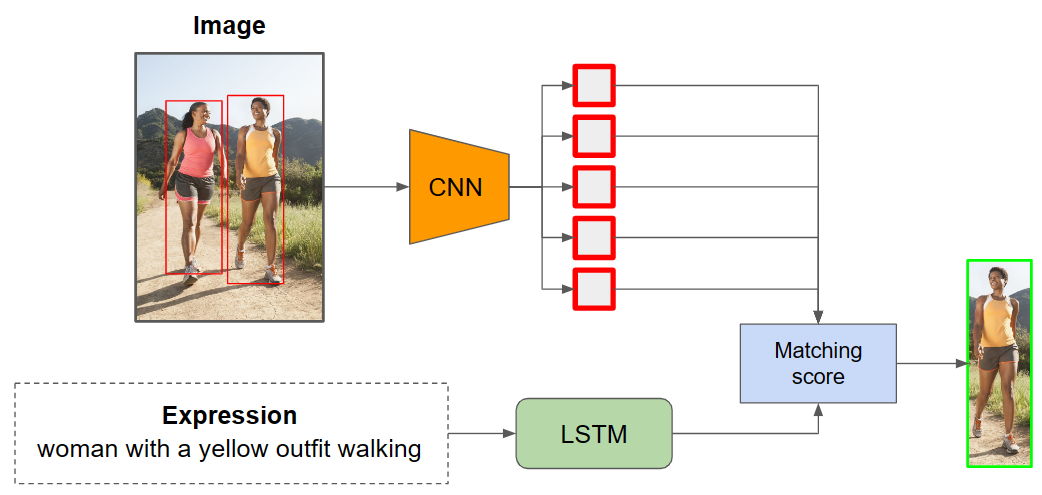

## Dataset

For the purpose of training and assessing the models presented in this report, we made use of the umd segment of the RefCOCOg dataset. This dataset contains an extensive assortment of 85'474 referring expressions, each corresponding to one of 54'822 unique objects present in 26'711 images.

The RefCOCOg dataset was adapted to our needs by agglomerating and reducing the key information to 2 csv:

- `refs.csv`
- `sentences.csv`

> `refs.csv`
>
> The single row refers to an image in the dataset and corresponds to a bounding box ground truth, expressed in `xyxy` coordinates

> `sentences.csv`
>
> The single row refers to a bounding box in `refs.csv` and corresponds to a possible textual description of the scene enclosed therein

In addition, the dataset was enriched with 3 csv:
- `bboxes[YOLOv5].csv`
- `bboxes[YOLOv8].csv`
- `bboxes[DETR].csv`

> `bboxes[V].csv`
>
> The single row refers to an image in the dataset and corresponds to a bounding box proposed by the `V` model, expressed in `xyxy` coordinates, complete with confidence level

This format allowed us to:
- remove the visual model from the training loop, resulting in increased training and evaluation speeds
- try different models by simply changing the reference `bboxes[V].csv`
- ensure the bounding boxes were not biasly sorted

Following a fail-fast style, first the csvs are read in full, then the `torch.data.Dataset` classes are defined.

For training and evaluation of the models presented in this report we use 3 `torch.data.Datasets`:

- `CocoDataset`
- `Coco4TrainingDataset`
- `Coco4ContrastiveDataset`

> `CocoDataset`
>
> The single item is a tuple with the original image in `torch.Tensor` format, the prompts, the bounding boxes proposed by the visual model, and the bounding box ground truth.
> `CocoDataset` filters the bounding boxes proposed by the model by setting a lowerbound on:
>
> - The confidence level
> - The width in pixels of the bounding box
> - The height in pixels of the bounding box

> `Coco4TrainingDataset`
>
> The single item, compared to the single item of `CocoDataset`, includes the crops of the original image.
>
> `Coco4TrainingDataset` filters bounding boxes like `CocoDataset`.
> `Coco4TrainingDataset` also filters items based on the number of bounding boxes found by the visual model.
> In fact, during the training phase, the model can only learn if it has at least two options to choose from.

> `Coco4ContrastiveDataset`
>
> The single item is the pair: original image crop ground truth and the prompts.

During training we use the batching technique offered by the `torch.data.DataLoader`.
Since the `torch.data.Dataset` so defined have items of variable size, it is necessary to define a custom data batching method. For this report, 2 were defined:

- `unzip`
- `augment`

> `unzip`
>
> From a list of tuples, returns a tuple of lists

> `augment`
>
> Given a list of `Coco4ContrastiveDataset` items, returns a visually and textually augmented version of it.

#### Dataset and type declaration

In [ ]:
if ! [ -d dataset ]; then
  gdown 1i-LHWSRp2F6--yhAi4IG3DiiCHmgE4cw &&
  tar -xf refcocog.tar &&
  rm refcocog.tar
fi

In [ ]:
path_root: str = os.path.join("refcocog", "")
path_annotations: str = os.path.join(path_root, "annotations", "")
path_bboxes: str = os.path.join(path_root, "bboxes", "")
path_images: str = os.path.join(path_root, "images", "")

path_refs: str = os.path.join(path_annotations, "refs.csv")
path_sentences: str = os.path.join(path_annotations, "sentences.csv")

path_DETR: str = os.path.join(path_bboxes, "bboxes[DETR].csv")
path_YOLOv5: str = os.path.join(path_bboxes, "bboxes[YOLOv5].csv")
path_YOLOv8: str = os.path.join(path_bboxes, "bboxes[YOLOv8].csv")

In [ ]:
Split = t.Literal["train", "test", "val"]


@dataclass
class Ref:
    ref_id: int  # unique id for refering expression
    file_name: str  # file name of image relative to img_root
    split: Split
    xmin: float
    ymin: float
    xmax: float
    ymax: float


with open(path_refs, "r") as f:
    raw = csv.DictReader(f)
    refs: list[Ref] = [Ref(**row) for row in raw]


In [ ]:
@dataclass
class Sentence:
    ref_id: int  # unique id for refering expression
    sent: str


with open(path_sentences, "r") as f:
    raw = csv.DictReader(f)
    sentences: list[Sentence] = [Sentence(**row) for row in raw]


id2sents: dict[int, list[str]] = groupby(
    sentences, lambda x: x.ref_id, lambda x: x.sent
)



In [ ]:
@dataclass
class BBox:
    file_name: str  # file name of image relative to img_root
    xmin: float
    ymin: float
    xmax: float
    ymax: float
    confidence: float


with open(path_DETR, "r") as f:
    raw = csv.DictReader(f)
    bboxes: list[BBox] = [BBox(**row) for row in raw]

img2detr: dict[str, list[BBox]] = defaultdict(
    list, groupby(bboxes, lambda x: x.file_name)
)


with open(path_YOLOv5, "r") as f:
    raw = csv.DictReader(f)
    bboxes: list[BBox] = [BBox(**row) for row in raw]

img2yolov5: dict[str, list[BBox]] = defaultdict(
    list, groupby(bboxes, lambda x: x.file_name)
)


with open(path_YOLOv8, "r") as f:
    raw = csv.DictReader(f)
    bboxes: list[BBox] = [BBox(**row) for row in raw]

img2yolov8: dict[str, list[BBox]] = defaultdict(
    list, groupby(bboxes, lambda x: x.file_name)
)



In [ ]:
TensorImage = UInt[torch.Tensor, "3 H W"]

In [ ]:
class CocoDataset(
    Dataset[
        tuple[
            TensorImage, list[str], Float[torch.Tensor, "X 4"], Float[torch.Tensor, "4"]
        ]
    ]
):
    def __init__(
        self,
        split: Split,
        img2bboxes: dict[str, list[BBox]],
        limit: int = -1,
    ):
        self.items: list[
            tuple[
                str, list[str], Float[torch.Tensor, "X 5"], Float[torch.Tensor, "1 4"]
            ]
        ] = [
            (img, sents, xyxys, xyxy)
            for ref in refs
            if ref.split == split
            for img in [os.path.join(path_images, ref.file_name)]
            for sents in [id2sents[ref.ref_id]]
            for bboxes in [img2bboxes[ref.file_name]]
            for xyxys in [
                torch.tensor([
                    (bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax)
                    for bbox in bboxes
                    if bbox.confidence > .25  # lower bound on confidence
                    if bbox.xmax - bbox.xmin > 16  # lower bound on width
                    if bbox.ymax - bbox.ymin > 16  # lower bound on heigth
                ])
            ]
            for xyxy in [torch.tensor([(ref.xmin, ref.ymin, ref.xmax, ref.ymax)])]
        ]
        self.len: int = len(self.items) if limit < 0 else min(limit, len(self.items))

    def __len__(self) -> int:
        return self.len

    def __getitem__(
        self, index: int
    ) -> tuple[
        TensorImage, list[str], Float[torch.Tensor, "X 5"], Float[torch.Tensor, "1 4"]
    ]:
        file_name, sents, xyxys, xyxy = self.items[index]
        return read_image(file_name, ImageReadMode.RGB).to(device), sents, xyxys, xyxy



In [ ]:
class Coco4TrainingDataset(
    Dataset[
        tuple[
            list[TensorImage],
            list[str],
            int,
            Float[torch.Tensor, "crops 4"],
            Float[torch.Tensor, "1 4"],
        ]
    ]
):
    def __init__(
        self,
        split: Split,
        img2bboxes: dict[str, list[BBox]],
        limit: int = -1,
    ):
        self.items: list[
            tuple[
                str,
                list[str],
                int,
                Float[torch.Tensor, "X 4"],
                Float[torch.Tensor, "1 4"],
            ]
        ] = [
            (img, sents, i, xyxys, xyxy)
            for ref in refs
            if ref.split == split
            for img in [os.path.join(path_images, ref.file_name)]
            for sents in [id2sents[ref.ref_id]]
            for bboxes in [img2bboxes[ref.file_name]]
            for xyxys in [
                torch.tensor([
                    (bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax)
                    for bbox in bboxes
                    if bbox.confidence > .25  # lower bound on confidence
                    if bbox.xmax - bbox.xmin > 16  # lower bound on width
                    if bbox.ymax - bbox.ymin > 16  # lower bound on heigth
                ])
            ]
            if xyxys.shape[0] > 1 # lower bound on bbox per image
            for xyxy in [
                torch.tensor([(ref.xmin, ref.ymin, ref.xmax, ref.ymax)])
            ]
            for ious in [box_iou(xyxys, xyxy)]
            if torch.max(ious).item() > .5  # ensure at least .5 of maximum IoU
            for i in [torch.argmax(ious).item()]
        ]
        self.len: int = len(self.items) if limit < 0 else min(limit, len(self.items))

    def __len__(self) -> int:
        return self.len

    def __getitem__(
        self, index: int
    ) -> tuple[
        list[TensorImage],
        list[str],
        int,
        Float[torch.Tensor, "crops 4"],
        Float[torch.Tensor, "1 4"],
    ]:
        file_name, sents, i, xyxys, xyxy = self.items[index]
        img: TensorImage = read_image(file_name, ImageReadMode.RGB).to(device)

        xywhs: Int[torch.Tensor, "X 4"] = box_convert(xyxys, in_fmt="xyxy", out_fmt="xywh").round().int()

        crops: list[TensorImage] = [
            crop(img, top=y, left=x, height=h, width=w)
            for xywh in xywhs
            for [x, y, w, h] in [xywh.tolist()]
        ]

        return crops, sents, i, xyxys, xyxy



In [ ]:
class Coco4ContrastiveDataset(Dataset[tuple[TensorImage, list[str]]]):
    def __init__(
        self,
        split: Split,
        limit: int = -1,
    ):
        self.items: list[tuple[str, list[str], Float[torch.Tensor, "1 4"]]] = [
            (img, sents, xyxy)
            for ref in refs
            if ref.split == split
            for img in [os.path.join(path_images, ref.file_name)]
            for sents in [id2sents[ref.ref_id]]
            for xyxy in [torch.tensor([(ref.xmin, ref.ymin, ref.xmax, ref.ymax)])]
        ]
        self.len: int = len(self.items) if limit < 0 else min(limit, len(self.items))

    def __len__(self) -> int:
        return self.len

    def __getitem__(self, index: int) -> tuple[TensorImage, list[str]]:
        file_name, sents, xyxy = self.items[index]
        img: TensorImage = read_image(file_name, ImageReadMode.RGB).to(device)

        xywh: Int[torch.Tensor, "1 4"] = box_convert(xyxy, in_fmt="xyxy", out_fmt="xywh").round().int()
        [[x, y, w, h]] = xywh.tolist()

        return crop(img, top=y, left=x, height=h, width=w), sents

In [ ]:
BATCH_SIZE: int = 256
LIMIT: int = 2 * BATCH_SIZE
EPOCHS: int = 50

## Evaluation metrics

Recent works [12][13] have shown that even subtle changes in the finetuning process can lead to surprisingly large differences in the final performance. In order to provide valuable comparisons between our solution proposals and to ensure that the implemented models are performing as intended, it is essential to evaluate them according to appropriate metrics. With the aim of quantitatively measure the capabilities of our algorithms, we have considered the following criteria.

### Localization accuracy

Localization accuracy (Formula 1) measures how accurately the fine-tuned network can ground the localized object to a language description. Intersection over Union (IoU) is a common measure of localization accuracy (Figure 3). In particular, we keep track of:
*   mean intersection over union (**mIoU**)
*   the fraction of correct predictions with respect to the total number of processed samples, considering an IoU threshold of 0.3 (**mAP [IoU .3]**). That is, the predicted bounding box $\hat{b}$ is considered correct (true positive) if the IoU between $\hat{b}$ and the ground-truth bounding box $b$ is at least 30%. This metric is usually referred to by the literature as *mean Average Precision* (mAP) [15].
* the fraction of correct predictions with respect to the total number of processed samples, considering an IoU threshold of 0.5 (**mAP [IoU .5]**)
* the fraction of correct predictions with respect to the total number of processed samples, considering an IoU threshold of 0.7 (**mAP [IoU .7]**)

### Semantic similarity

Semantic similarity (Formula 2) measures the similarity between the predicted bounding box $\hat{b}$ and the portion of the image which corresponds to the ground-truth bounding box $b$. Consider the output proposed in Figure 4. The neural network predicts the red bounding box $\hat{b}$ while in the dataset the green bounding box $b$ is the annotated ground-truth. Evidently, the algorithm response does not represent a true mistake. Conceptually, the two portions of the picture delimited by $\hat{b}$ and $b$ are semantically equivalent. For the purpose of computing the semantic similarity between two crops we evaluate the mean cosine similarity (**mCos**) and the mean euclidean distance (**mED**) between the $\hat{b}_z$s and the $b_z$s which are the latent space representations of the predicted bounding boxes $\hat{b}_z$s and the ground-truth bounding boxes $b$s respectively. In order to achieve a fair comparison, we consistently use the original CLIP visual encoder (`encode_image()` method) to geometrically represent a cropped portion of the image with a vector of size 1024 (Figure 5).

**Formula 1**

$d(b_z, \hat{b}_z) = ||b_z - \hat{b}||$

**Formula 2**

$S_C(b_z, \hat{b}_z) = \frac{b_z \cdot \hat{b}_z}{\lVert{} b_z \rVert{} \lVert{}\hat{b}_z\rVert{}} = \frac{\sum_{i=1}^{n}b_{z_i}\hat{b}_{z_i}}{\sqrt{\sum_{i=1}^{n}b_{z_i}^2 \cdot \sum_{i=1}^{n}\hat{b}_{z_i}^2}}$

**Figure 3**

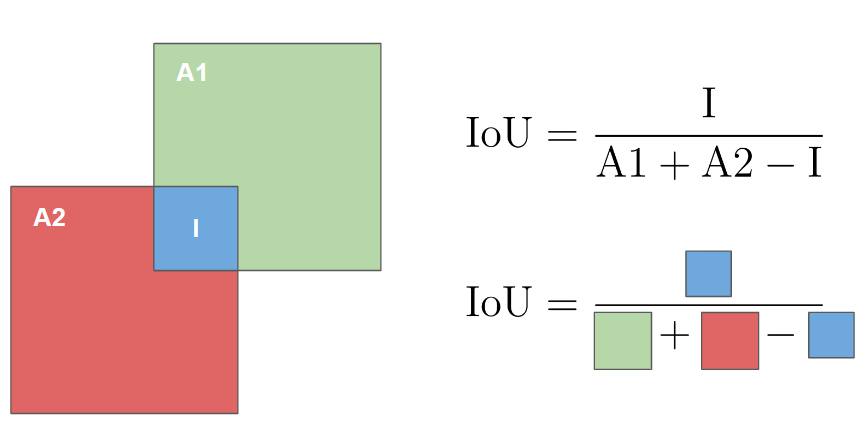

**Figure 4**

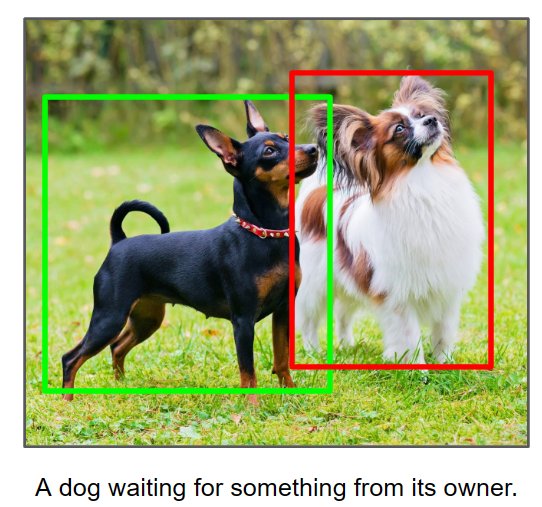

**Figure 5**

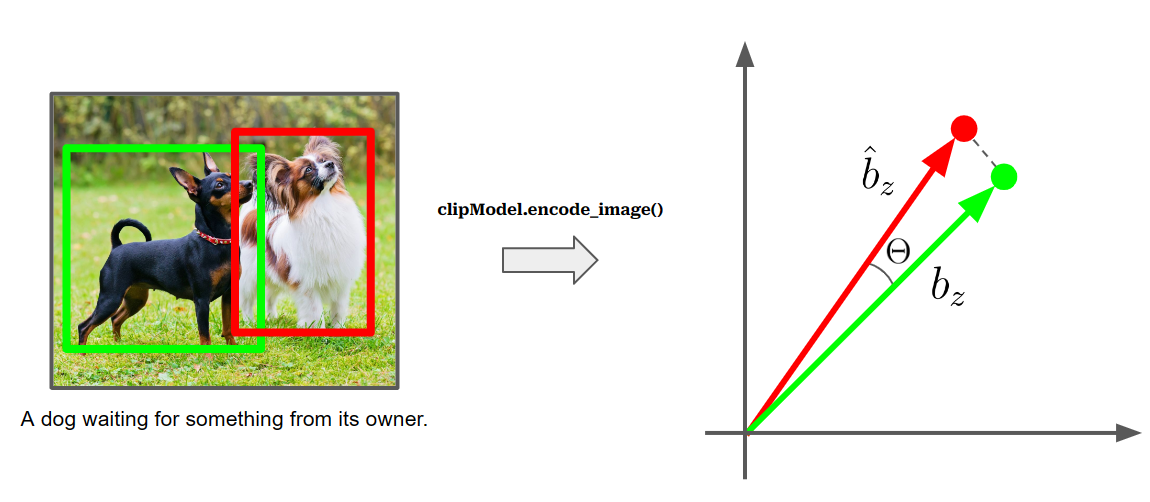

## Baseline

In [ ]:
%tensorboard --logdir ./assets/baseline/runs --port 6001

At the beginning of our project we have implemented a training free baseline algorithm. The development of this solution, hereafter usually referred to as `BASELINE`, has been profitable since it allowed us to familiarize ourselves with the task of visual grounding, the dataset being used and the CLIP model. Moreover the evaluation of the obtained results has pointed out several interesting aspects including things that can be improved and an approximate understanding of the performance that our further solutions should obtain.

The purpose of this section is to describe how the baseline algorithm works, report the obtained performance and provide a readable implementation of the described functionalities.

The method is a training-free approach that combines CLIP zero-shot with a Yolo architecture [14]. More in depth, we rely on the Yolov5 implementation provided by TorchHub at the following link [Ultralytics Yolov5](https://pytorch.org/hub/ultralytics_yolov5/). The computational process involves extracting all the bounding boxes proposed by Yolo and evaluating their similarity with the textual query. In order to make comparisons between crops and prompts we rely on CLIP visual encoder (`encode_image()`) and CLIP text encoder (`encode_text()`) respectively, in order to map texts and images into the same latent space. This done, visual and textual prompts are represented as vectors belonging to the same 1024 dimensional vector space. At this point, the vectors which correspond to the embedded crops ($\hat{b}_{z_1}, ..., \hat{b}_{z_N}$) can be compared with the prompt encoding ($p$) using cosine similarity function ($S_C$). At the end of the day, the output of the execution is the bounding box corresponding to the vector $\hat{b}_{z_i} \in \{\hat{b}_{z_1}, ..., \hat{b}_{z_N}\}$ characterized by the highest similarity with the latent space representation of the textual prompt. For the sake of clarity we propose a schematic illustration of the overall architecture in Figure 6 and Figure 7.


**Figure 6**

The first step of the baseline is to perform object detection with Yolov5 algorithm.

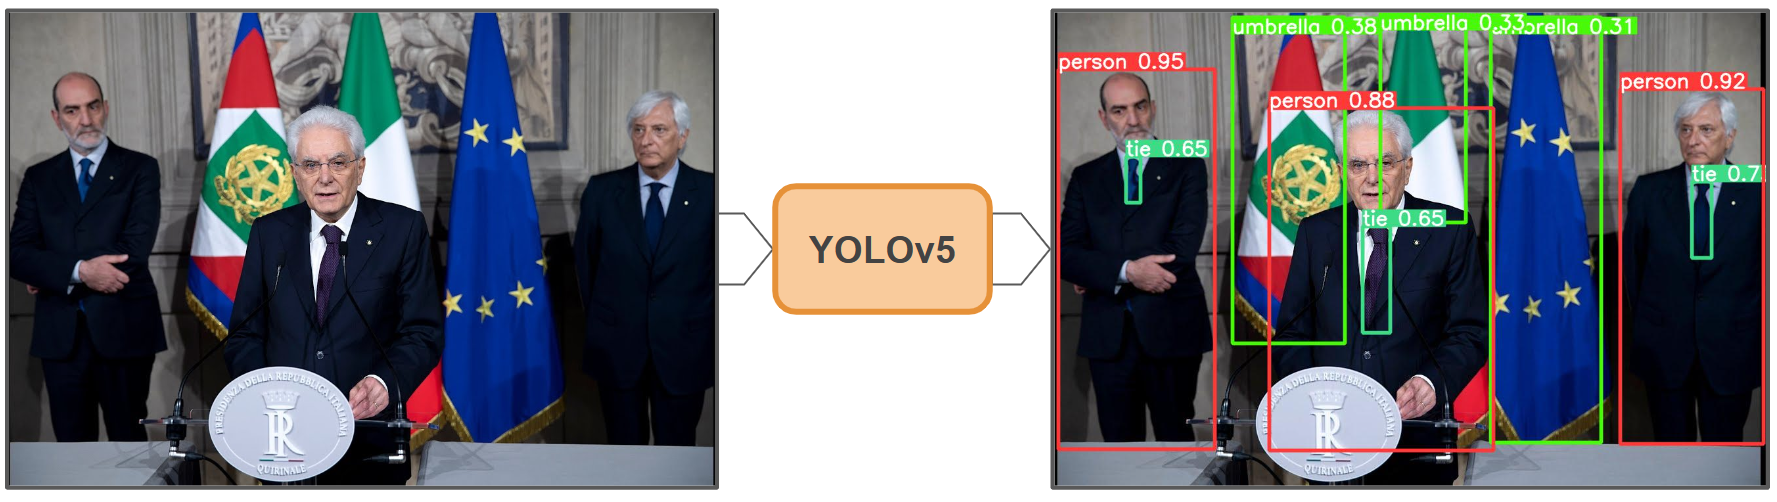

**Figure 7**

The purpose of the second step of the baseline algorithm is to compare the vector embeddings of the previously extracted crops with the latent space representation of the input prompt $p$. The overall output is the bounding box $\hat{b}_{z_i}$ which corresponds to the vector characterized by the highest similarity with respect to vector $p$. Reasonably, we rely on the cosine similarity function $S_C$ to do the comparison.

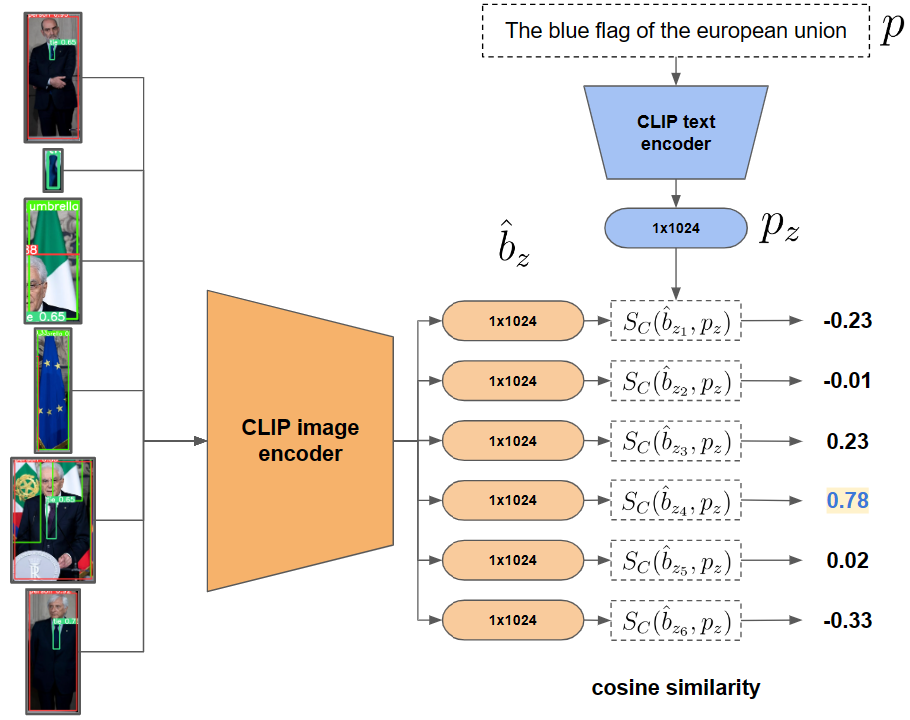

### Results

Although our zero-shot `BASELINE` involves no additional training at all, it achieves very good performance on our downstream task. The obtained results are reported in the following table.

### Observations

In the described two steps `BASELINE` algorithm the comparison of the image crops embeddings and the latent representation of the given textual prompt in order to identify the bounding box which is most similar to the given description, is computed among the regions of the input image proposed by Yolov5. As a consequence, the goodness of the predicted bounding box at the end of the execution is inevitably strongly related to the quality of the bounding boxes proposed by the former detection step. More broadly, being $\hat{b}_{\text{max}}$ the bounding box predicted by Yolov5 characterized by the highest intersection over union with the dataset ground truth bounding box, the localization accuracy of the BASELINE have an upper bound which is the average intersection over union between the $\hat{b}_{\text{max}}$s and the corresponding ground truths. In this regard, a good starting point to improve the performance is to replace Yolov5 with another region proposal algorithm which succeeds in suggesting better bounding boxes, i.e. rectangles with a higher intersection over union with the annotated ground truth.

By means of a manual inspection of the regions proposed by Yolo, we have noticed that some crops are very small areas characterized by few pixels (Figure 8). In general, it does not make sense to consider these portions which clearly make the overall computation more expensive. A simple solution to overcome this is to discard all the bounding boxes whose edges are both smaller than a given threshold.

We assess that the two steps pipeline of the BASELINE algorithm in which the predicted bounding box is chosen on top of the regions proposed in the first stage of the algorithm, is reasonably appropriate to tackle the problem. In the process, CLIP is used to map the image crops and the input prompt into a mutual latent space. The final answer of the algorithm strongly depends on the ability of CLIP to extract good features. For the purpose of improving the performance of our implemented solution, we believe that the most promising strategy is to apply transfer learning to fine-tune the CLIP image encoder and text encoder architectures in order to extract features which are more discriminative for our narrow domain. Intuitively, from a high level point of view, using more specialized features for the task at hand, leads necessarily to a better and more valuable end-to-end representation of visual and textual prompts, and therefore a finest comprehension of the scene. In Section nn, nn and nn we present the solutions that we have come up with in order to further improve performance via supervised finetuning.

In our reference dataset there are a lot of samples which include spatial relationships (Figure 9). In general, the baseline model has displayed good results on appearance-based descriptions that are independent of viewer perspective. However, the algorithm struggles in the presence of location words such as "the dog on the left", in the textual descriptions. We consider this limitation and describe our attempt to mitigate it in Section nn.

Finally, in this first implementation, we always based our predictions on a single textual prompt which describes the portion of interest. However, in the dataset there are sometimes  more than one description for a given ground truth bounding box. In the following of this paper we describe our approach to consider more than one prompt in order to output more accurate predictions. More widely, in this regard in Section nn, we further investigate the chance of using data augmentation to improve the generalization capabilities of our final model.


**Figure 8**

Three crops proposed by Yolo. Evidently, two of them are meaningless and are too small to accomodate interesting portions of the picture.

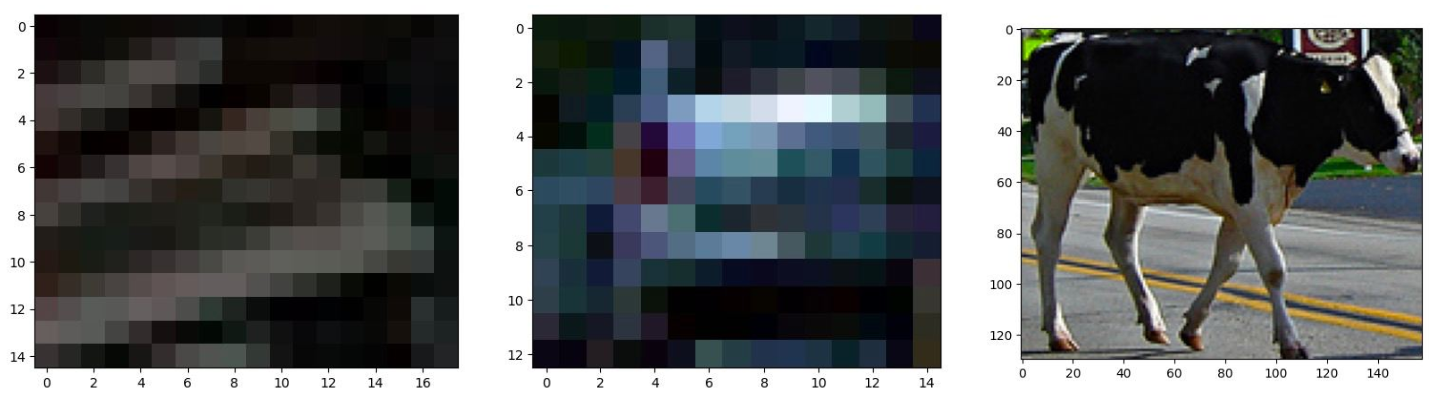

**Figure 9**

We have notices that the `BASELINE` algorithm has severe issues in dealing with spatial relationships. For instance in this case it has difficulties in choosing between the two dogs in the picture.

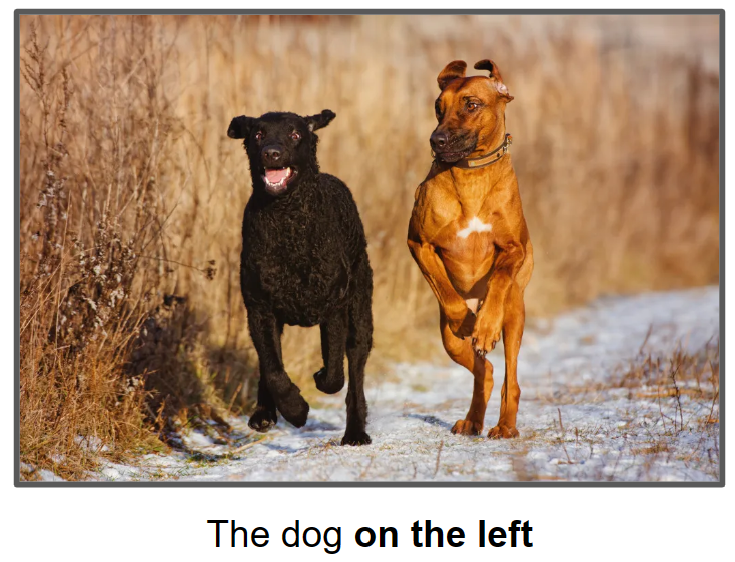

## Approach

Motivated by these observations, in this work we propose a two steps joint embedding algorithm to solve the visual grounding problem. The general framework is depicted in Figure 10.

The purpose of the first stage is to select a collection of regions of interest in the input image. To this end we need a deep learning model which predicts a set of bounding boxes which frequently contains a bounding box with high intersection over union with the ground truth bounding box of the RefCOCOg dataset.

In the second phase we incorporate our fine-tuned versions of the CLIP visual and textual encoders to encode the image regions delimited by the proposed bounding boxes and the referring expression into the same vector space. By doing so we can locate the portion of the image which is more in line with the given natural language description by means of the cosine similarity function as proposed in our baseline.

**Figure 10**

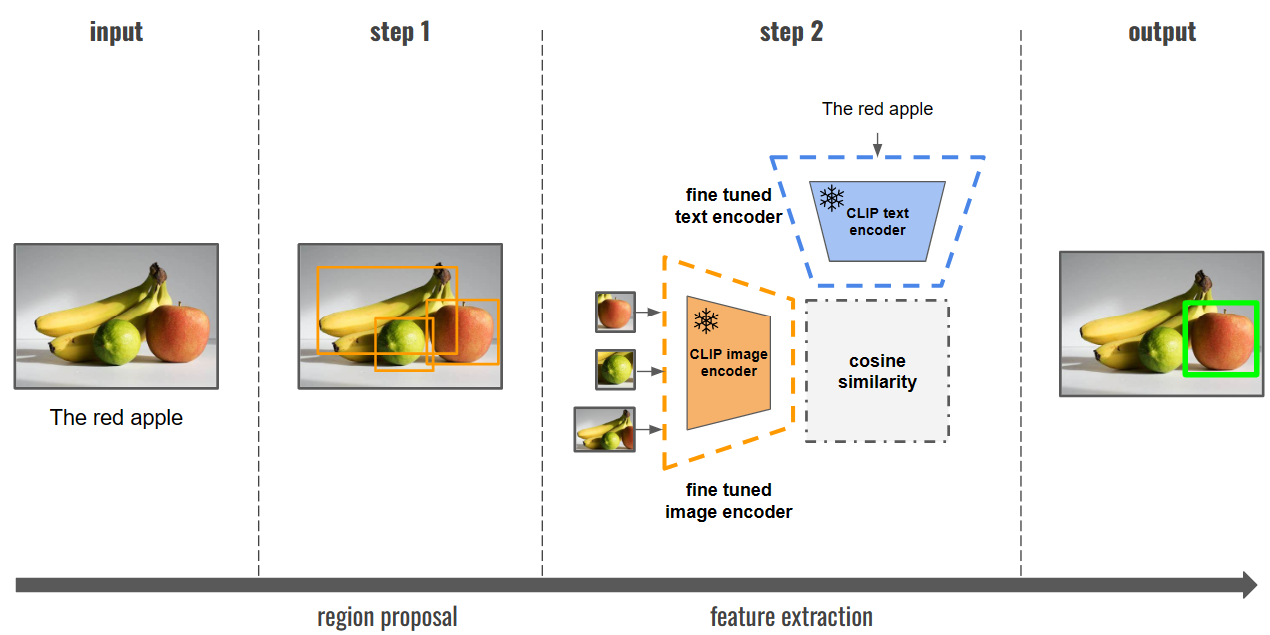

## Region proposal algorithms

In consonance with the schema proposed in Figure 10, the purpose of the first step of our algorithm is to propose potential regions of interest within the field of view. Understanding the location of the relevant objects in a given scene is a trivial task for humans. However, the development of a software agent with such a capability has been an uphill task until the turn of the last decade [15]. In recent years, the computer vision literature has proposed several models to accomplish this task motivated by a huge range of possible applications. In the `BASELINE` algorithm we have employed the widely used Yolov5 model. As mentioned above, the goodness of the bounding box proposed at the end of the overall execution is inherently related to the quality of the bounding boxes proposed by Yolov5. More in depth, being $\hat{B}=\{\hat{b}_1, …, \hat{b}_N\}$ the set of bounding boxes proposed by Yolov5 and $\hat{b}_{\text{max}} \in \hat{B}$ the proposed bounding box characterized by the highest intersection over union with the dataset ground truth bounding box $b$; the localization accuracy of the final predicted bounding box is necessarily limited superiorly by the IoU($\hat{b}_{\text{max}}, b$). In addition to this, also the cardinality of $B$ is not negligible. Actually, the computational complexity of the successive iterations depends on the number of bounding boxes to be evaluated. Based on this observations, we have tested multiple object detection algorithms made freely available by the authors with the aim of finding out the most performing one on our dataset. To this end, we have considered some of the state-of-the-art methods listed by paperswithcode.com [16]. Particularly, in this project we have executed Yolov5 [14], Yolov8 [17] and DETR [18]. For the sake of a proper comparison, all the algorithms have been configured with the same level of confidence. The obtained results are reported in Table ?. As we can see, though all the models perform decently, it turns out that DETR provides the best tradeoff between number of bounding boxes and average IoU with the dataset ground truth. Ultimately, in the following of the project all the presented results have been achieved on top of the regions proposed by DETR.


### Bounding box preprocessing
As exhaustively written in Section nn and depicted in Figure 10, once the first step of the overall algorithm has been completed, the obtained bounding boxes are not further refined in the following of the execution. Therefore, we have decided to preprocess our entire dataset in order to fill it with the bounding boxes proposed by the aforementioned object detectors. In doing so we have considerably speeded up the overall computational execution without incurring any loss of generality. A single epoch without this preprocessing last ?? on average. On the other hand, with this enhancement we complete an epoch iteration in ?? seconds. As a consequence of this, we have been able to make more experiments and to train our models on more data for a longer time. We believe that this preprocessing can be potentially applied on countless deep learning domains. Hence, as an important contribution of our work we have made available at this GitHub repository the code to compute this preprocessing with whatever object detection algorithm. Moreover, in the repo, we have conveniently published `yolov5.csv`, `yolov8.csv` and `detr.csv` files including the results calculated by the three aforementioned object detectors.

## Standard fine-tuning

Given a set of proposed bounding boxes $\hat{B}=\{\hat{b}_1, …, \hat{b}_N\}$ and a natural language description $p$ referring to one of them, the purpose of the second step of our solution proposal, is to map both visual and textual prompts into a mutual vector space. In the latent space, the bounding boxes and the referring expression are represented as vectors of features. Given that these vectors share a common geometrical space, they have the same dimensionality. As a consequence, we can mathematically compare the visual information within the bounding boxes with the semantic of the provided description simply using cosine similarity. In this way, our algorithm can state which is the image region more in line with the input expression.

Evidently, the tough part of this road map is the definition of a meaningful mapping between visual and textual information. To this end, we rely on the powerful pretrained CLIP model recently proposed by OpenAI [2]. More specifically, the deep neural network provides a visual encoder $\Psi: I \rightarrow Z$ and a textual encoder $\Gamma: P \rightarrow Z$ such that given respectively an image $i \in I$ and a text $p \in P$ as input, they produce two latent space representations $i_z, p_z \in Z$ united by a joint 1024 dimensional vector space. In our `BASELINE` algorithm (Section nn) we apply the two encoders with no additional training. Although the two networks have achieved reasonable performance and robustness, motivated by several previous works [19][20][21] our aim is to fine-tune the two architectures in order to make them more proficient in our downstream task. Intuitively, applying transfer learning, our attempt is to build two encoders ($\Psi^*, \Gamma^*$)  which are trained in order to provide more refined text and image feature descriptions for our narrow domain. Ultimately, a more characterizing representation of visual and textual prompts leads straightforwardly to a more accurate image-text comparison and consequently a more conscious identification of the final bounding box. The adoption of a pretrained model, not only saves precious computational costs and allows us to benefit from state-of-the-art models without having to train one from scratch, but it also reduces the carbon footprint, which is one of the major concerns of contemporary scientific literature [22].

As a first attempt to accomplish our objectives we have experimented with standard fine-tuning procedures that add multilayer perceptrons on top of the freezed pretrained architecture. Specifically we have designed, developed, trained and evaluated the following architectures:
*   `network 1` (Figure 11). In this architecture we fine-tune only the image encoder module of CLIP while preserving the pretrained weights of the textual counterpart. We add a non linear activation function (ReLU) and a linear head on top of the 1024 CLIP features. The deep neural network has been trained with Stochastic Gradient Descent optimizer. The implementation of this architecture is reported in Section nn.
*   `network 2` (Figure 12). In this second standard fine-tuned architecture, we add a bottleneck on top of the 1024 features proposed by CLIP. Having such a shrinkage encourages the network to compress feature representations to best fit in the available space. This time, both the image encoder and text encoder are fine-tuned symmetrically. The deep neural network has been trained with Stochastic Gradient Descent optimizer. The implementation of this architecture is reported in Section nn.
* `network 3` (Figure 13). This third architecture resembles the previous one. We maintain the idea of the bottleneck but we use a different activation function in the text encoder portion of the network. The neurons of the natural language processing portion of the network are activated by a Sigmoid. Moreover, for the sake of experimenting as much as possible, this network is trained with Adagrad optimizer instead of SGD. The implementation of this architecture is reported in Section nn.
* `network 4` (Figure 14). In this network we try to reduce the number of features of the final output layer. To accomplish this we append a linear head with 1024 input features and 512 output neurons on top of CLIP text and image encoders. As in the case of `network 1` we use the ReLU activation function and the SGD optimizer.
The listed architectures are conveniently summarized in Table ?.

Throughout the epochs we keep track of the loss and of the accuracy on the training and validation sets. Recalling that in this stage the algorithm should predict the bounding box proposed by DETR in step 1 characterized by the highest IoU with the dataset groundtruth, the most suitable loss function to be minimized is cross entropy loss. On the other hand, as a representative metric to quantify the accuracy in the predictions, we annotate the average intersection over union.

We have trained each of these architectures on Azure GPUs (see Section nn) for 1.5 hours in order to figure out the effects of the various design choices. With the aim of saving precious computational resources but at the same time achieving a meaningful comparison of the proposed architectures, we have systematically limited the dataset. As described in Section nn, this last contains more than one annotation for a given image. Consequently, for the purpose of maximizing the number of images inspected by our apprentice software agent, we consider only one annotation for every image. Since the dataset is still too large for this first sequence of tests, we have further reduced its cardinality by selecting a random subset of training items.

The obtained results are reported in the following tables and graphs. As we can see all the networks perform decently well and except `network 3` they all display ideal training curves. Looking at the loss and accuracy curves of the third standard fine tuned neural network, we clearly understand that Adagrad converges much slower than Stochastic Gradient Descent.
From these preliminary tests, we notice that though the standard finetuning approach is reasonable, it seems inappropriate to achieve satisfactory improvements with respect to the `BASELINE` solution. In the following section we describe a contrastive learning based fine-tuning solution alternative which immediately displays more promising results.


**Figure 11**

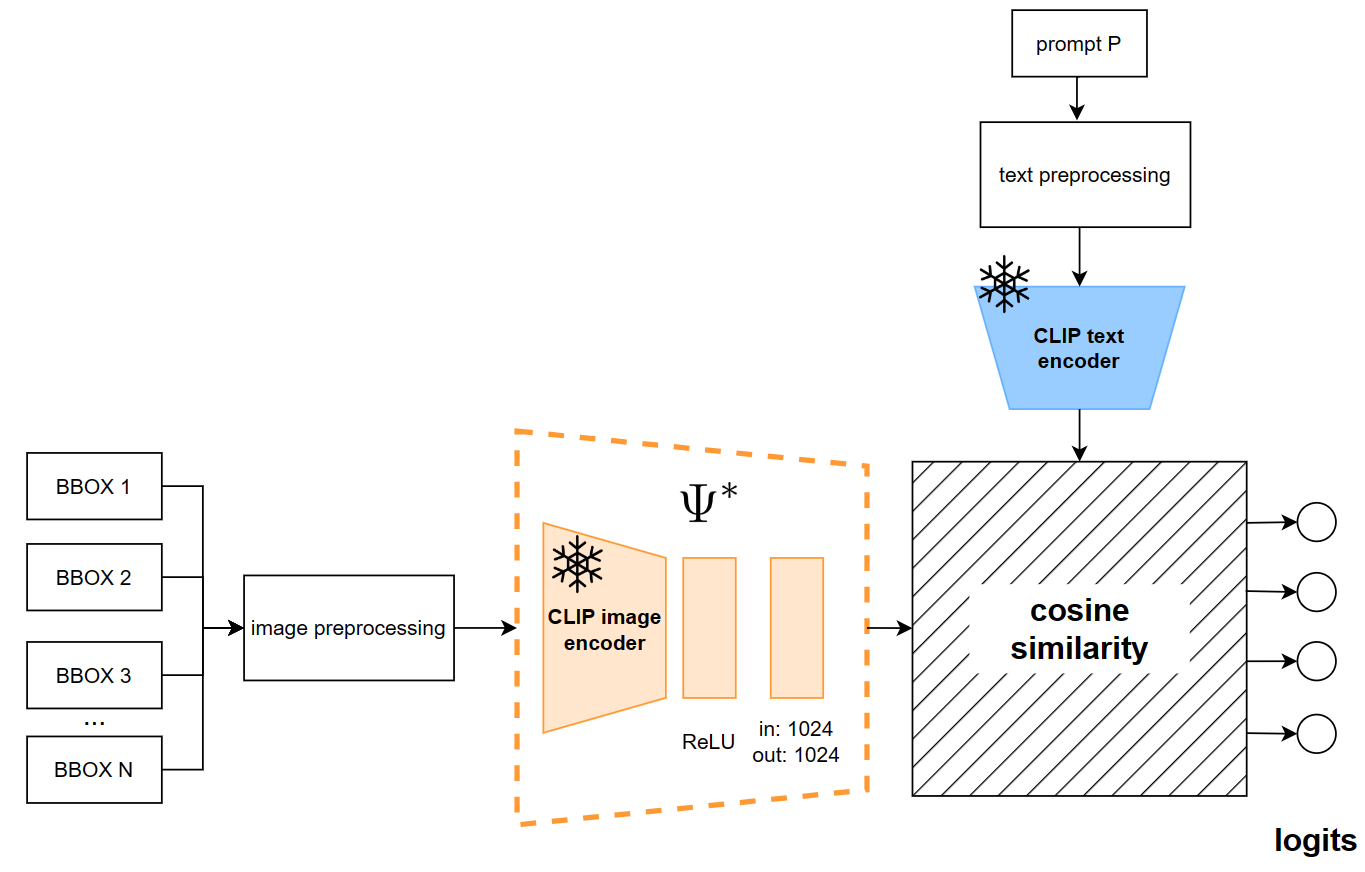

**Figure 12**

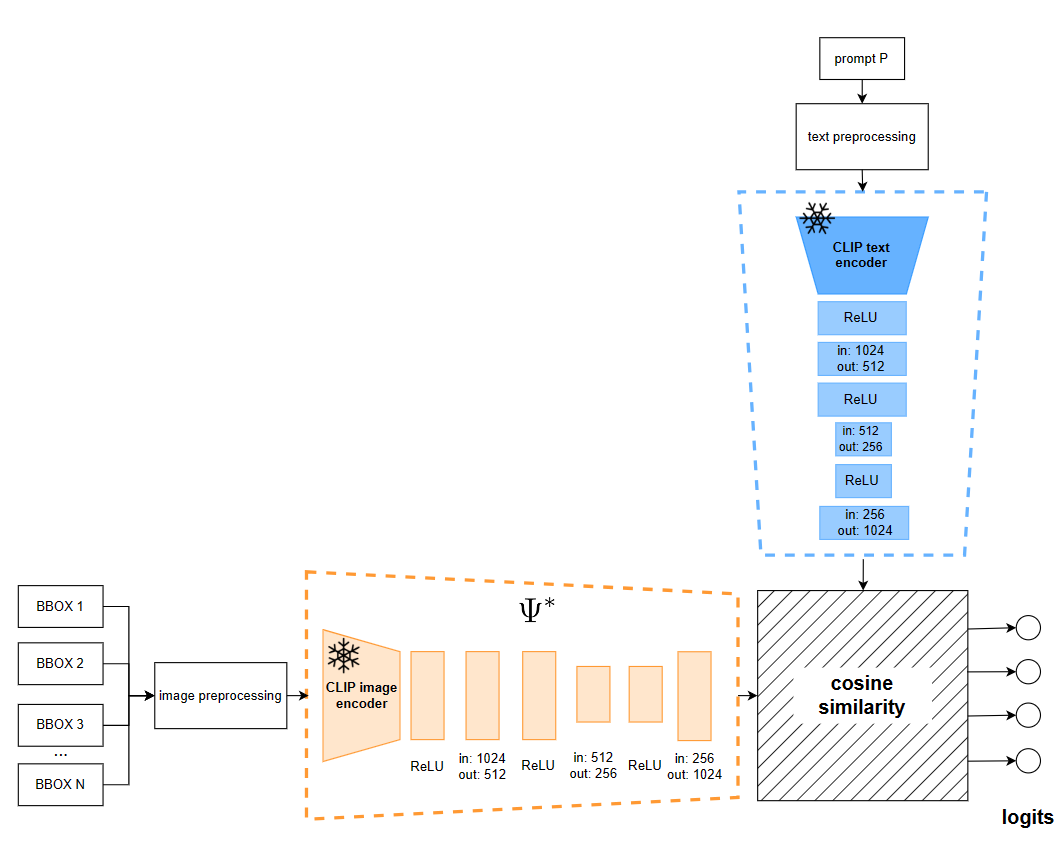

**Figure 13**

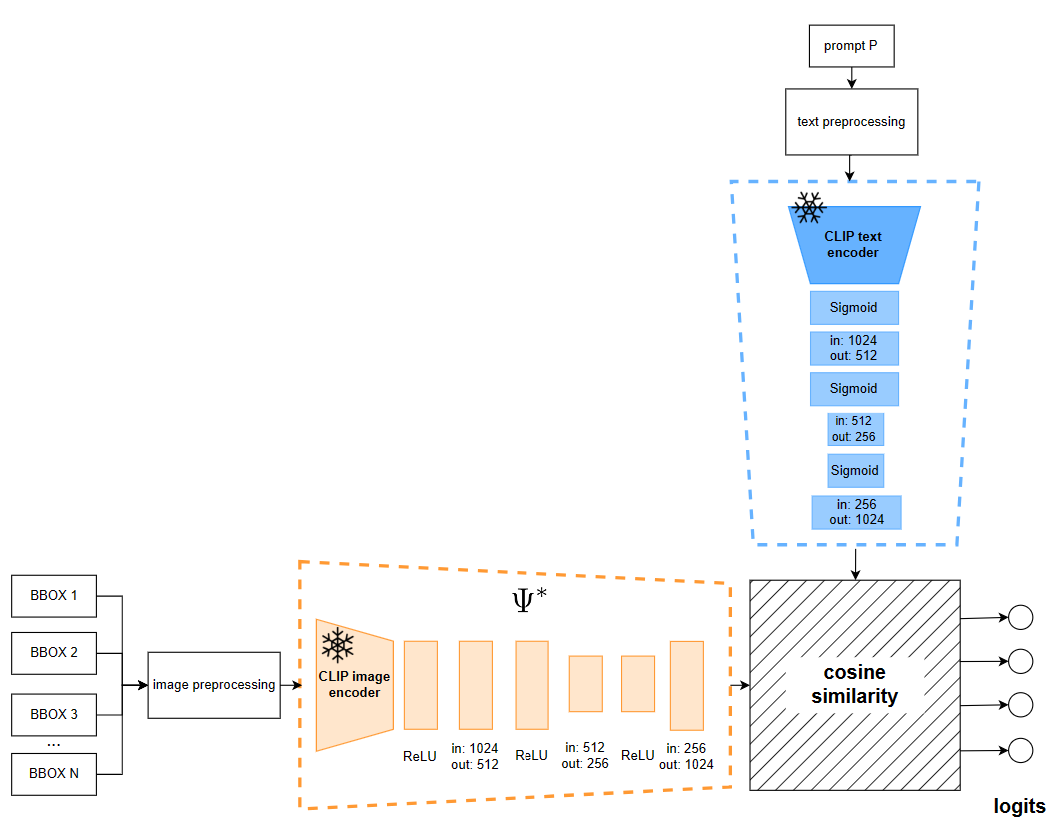

**Figure 14**

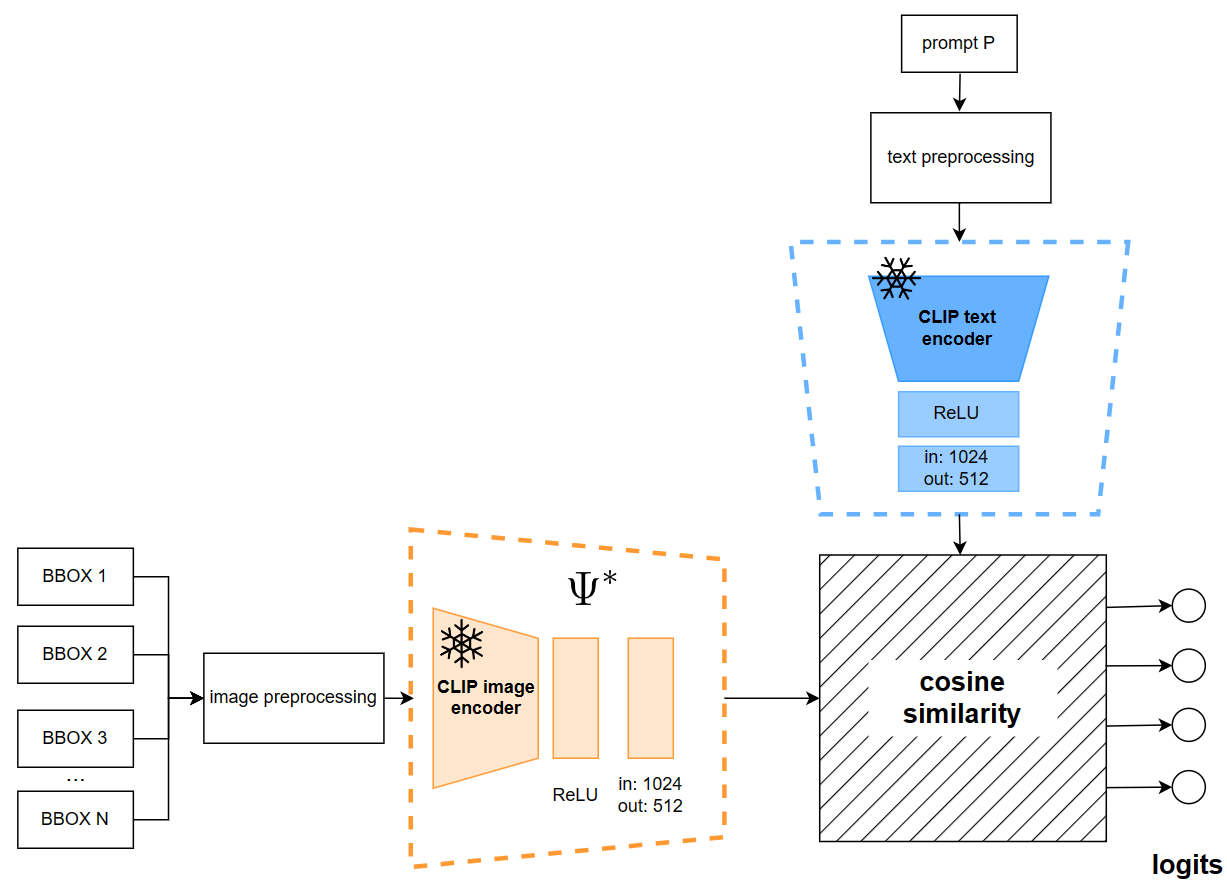

## Fine-tune like you pretrain


In [ ]:
%tensorboard --logdir ./assets/flyp/runs --port 6003

In [ ]:
%tensorboard --logdir ./assets/flyp-solve-overfitting/runs --port 6004

In [ ]:
%tensorboard --logdir ./assets/flyp-optuna/runs --port 6005

In [ ]:
%tensorboard --logdir ./assets/flyp-augmented/runs --port 6006

One of the trickiest aspects of standard fine-tuning approaches lies in the understanding of the role of the subtle applicable changes since there is no simple rule of thumb for what is the correct modification. As an alternative methodology to standard fine-tuning techniques, inspired by the work of Sachin Goyal et al. "Finetune like your pretrain: Improved finetuning of zero-shot vision models" [5], we propose to finetune the visual and textual encoder components of CLIP via the same pretraining process employed by the original authors of the model.

More precisely, the purpose of CLIP is to learn a multi-modal embedding of image and text.

Let $\Psi: I \rightarrow \mathcal{R}^d$ denote the image encoder that maps an image to a $d$-dimensional image-text embedding space. $\Psi$ is parameterized by parameters $\theta_{\text{img}}$.

Let $\mathcal{P}$ be the space for text descriptions of images. Analogously, $\Gamma: \mathcal{P} \rightarrow \mathcal{R}$  is the language encoder with model parameters $\theta_{\text{text}}$.

The backbone of the pretraining objective is contrastive learning, where the goal is to align the embedding $\Psi(I_i)$ of an image close to the embedding $\Gamma(P_i)$ of its corresponding text description, and away from other text embeddings $\Gamma(P_j)$ in the batch.

Given a batch with $B$ images with their corresponding text descriptions $D = \{(I_1, P_1), \ldots, (I_B, P_B)\}$, pretraining objective is formally formulated as follows:

$$
\mathcal{L}_{\text{pre}}(D, \theta) :=
\sum_{i=1}^{B} -\log{\frac{\exp(\bar{f}(I_i) \cdot \bar{g}(P_i))}{\sum_{j=1}^{B}\exp(\bar{f}(I_i) \cdot \bar{g}(P_j))}} + \sum_{i=1}^{B} -\log{\frac{\exp(\bar{f}(I_i) \cdot \bar{g}(P_i))}{\sum_{j=1}^{B}\exp(\bar{f}(I_j) \cdot \bar{g}(P_i))}}
$$

where

- $\theta = [\theta_{\text{img}}, \theta_{\text{text}}]$ are image and text encoder parameters
- $\bar{f}$ and $\bar{g}$ are the $l_2$ normalized versions of $f$ and $g$ respectively.

In other words, as a result of the minimization of this objective function, the algorithm maximizes the cosine similarity of the image and text embeddings of the $N$ real pairs in the batch while minimizing the cosine similarity of the embeddings of the $N^2-N$ incorrect pairings.

In consonance with this promising direction we have designed, developed and trained a contrastive learning architecture as summarized in Figure ?. As depicted in the proposed illustration, we append a symmetric linear head on both the pre-trained CLIP encoders, where to accommodate our trainable parameters. Moreover, for the purpose of training the architecture we have implemented a second customized dataset class together with the corresponding data loaders. Indeed, the input and output of our network to be trained are significantly changed. In order to successfully apply contrastive learning, at each iteration we need to compare a collection of $B \in \mathcal{N}$ ground truth bounding boxes with their corresponding $B$ textual descriptions. Throughout the training epochs the goal is to maximize the cosine similarity between the crop-text couples which actually occur in the batch while minimizing the cosine similarity of the other pairs. To this end we have personalized the loss function proposed by [this GitHub repository](https://github.com/locuslab/FLYP/) whose code has been made available by the authors of the aforementioned "Finetune like you pretrain" paper [5]. On the other hand, unfortunately, in [the official GitHub repository of CLIP](https://github.com/OpenAI/CLIP) there is not the implementation of the original procedure used to train the model. Fortunately, we have been able to personalize for our scopes the code published at [this GitHub repository](https://github.com/mlfoundations/open_clip/) whose goal is to enable the training of models with contrastive image-text supervision. At the end of the day, the implementation follows closely the pseudocode proposed in the paper of CLIP that we conveniently report in Figure ?.

The resulting training procedure is extremely computationally efficient both in terms of time and memory consumption. Consequently, we have been able to train our fine-tuned image and text encoders on the whole dataset for many epochs in a reasonable amount of time. Also in this case, stochastic gradient descent has been the optimizer of choice. As regards the cardinality of the batches, contrastive learning procedures tend to provide better outcomes with larger batch sizes [23 TODO: nota questo paper è a caso, vedere se si trova altro]. Intuitively, considering only one (image, text) pair at a time, i.e. a batch size of 1, the resulting contrastive loss is completely meaningless. Remarkably, with our proposed implementation we have succeeded in using a batch size of 1024 (image, text) pairs without exceeding memory limits.

Once the two multi-modal encoders $\Psi^*, \Gamma^*$ have been symmetrically finetuned by the above-mentioned training strategy, we have tested their acquired skills on our downstream task. The obtained results are reported at the end of this section. The performance obtained by the model is impressive and outperforms all the previously proposed standard finetuning networks.


**Figure 15**

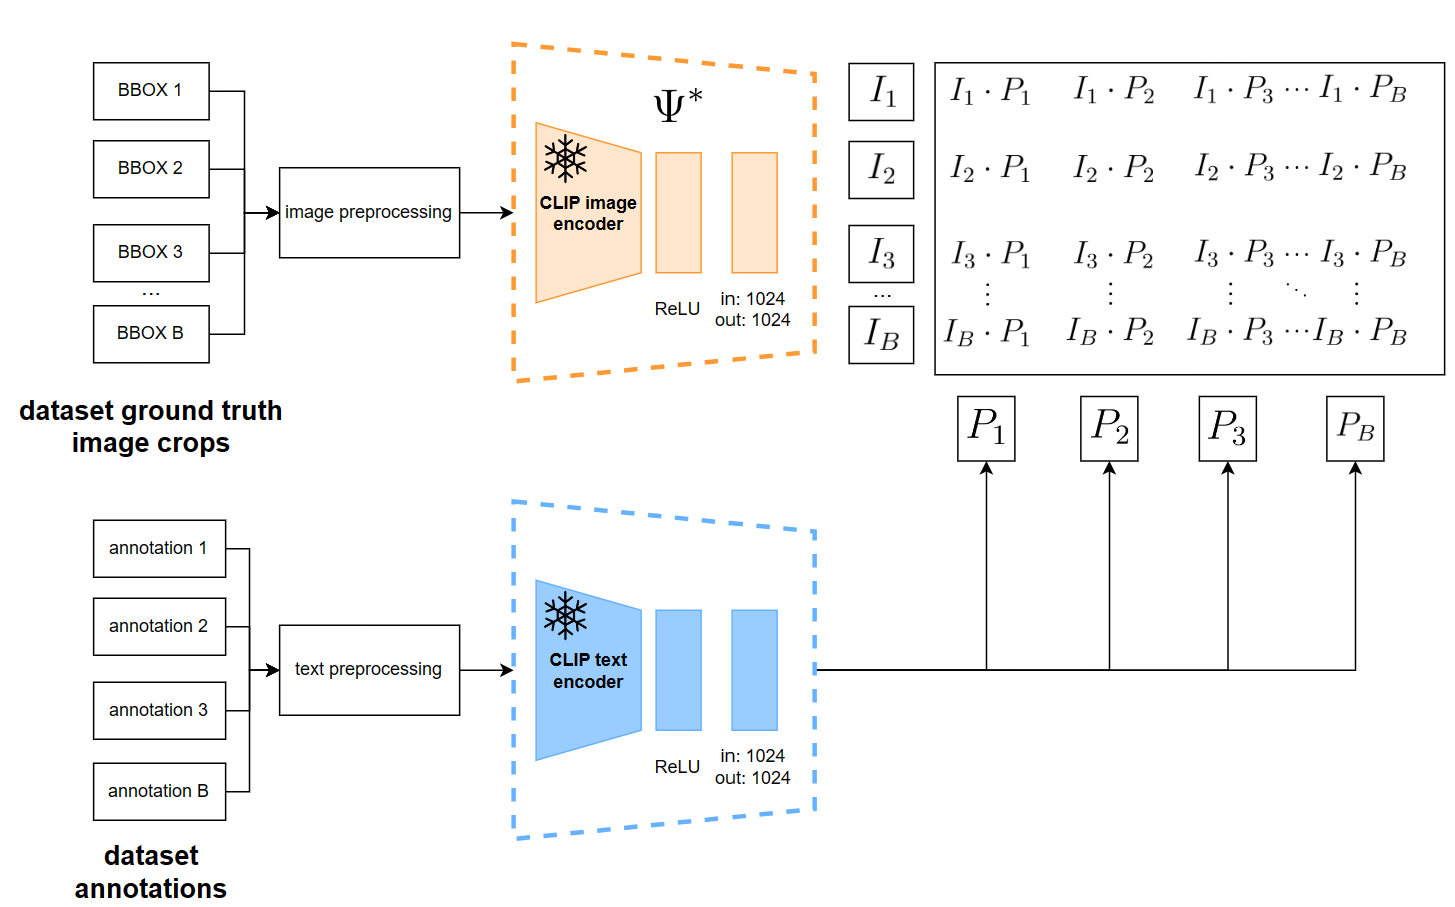

### Observations

Looking at the training curves in the plot depicted in Figure ?, we can evidently understand that during training the model has overfitted around epoch 10. Gladly, the displayed behavior strongly suggests that there is still space for improvement with this architecture.

Pursuing our objectives, we have refined the neural network and the training procedure by incorporating regularization techniques in order to prevent overfitting. Specifically, in our improved implementation we consider the following strategies.
early stopping: we save the state of the network at the end of every epoch. Notably, the tweak poorly affects the speed of the computation. Following this strategy, after training, we can manually inspect the training and validation error and easily select the most optimal version of the model.
dropout: we add a dropout that randomly shuts down some fraction of the layers’ neurons at each training step by zeroing out their values.

The effects of the application of these effective regularization strategies can be appreciated by the reader at the end of this subsection. Manifestly, the training curves now exhibit an optimal descending behavior. The encouraging trend is visually reflected in the matrices shown in Figure ? and Figure ? in which the color of the diagonal becomes progressively brighter throughout the training process.

Consistently with the improvements in the training objective, also the evaluation on the visual grounding downstream task of interest has produced astonishing results as reported in Table ?.


## Exploiting self-attention to provide contextualized latent space representations

As demonstrated by the numbers achieved by our fine-tuned architecture on the test set of the RefCOCOg dataset, our trained model is very well prepared in mapping the visual appearance of the image regions delimited by the proposed bounding boxes together with the semantic of the given textual description. Even though the algorithm achieves remarkable results, by manually inspecting the wrong predictions we have noticed that the AI agent makes mistakes in presence of location words such as "in the middle", "on the right", "on the left" and similar. However, if we carefully reason about the pipeline pursued by our software to make the final prediction (Figure ? la prima con tutto) we understand that the described deficiency is justifiable. Intuitively, with our implementation, the model can merely look at each image region proposed in step 1 in isolation, disregarding the surrounding elements which populates the field of view. Under such circumstances even a human would be in trouble in understanding which is "The dog on the left" and which is "The dog on the right" (Figure ? quella con i cani). In order to figure out which is the dog referred to by the natural language description, we need to grasp the content of the picture as a whole. Even though achieving a general understanding of the global scene is easily solvable in less than one second by a human observer, the task is not trivial for a machine. The purpose of this section is to describe our solution proposal to partially overcome this limitation.

The crucial observation behind the idea that we have come up with in order to accomplish this, is that we need a way to enhance the latent representations of visual and textual prompts so that the obtained encodings embody the overall context of the given picture. Intuitively, the image crops and the textual description have to be interpreted as words in an arbitrary long sentence. The encoding of a bounding box region, just as a pronoun, might acquire different meanings depending on the rest of the portrayed phrase. Consistently with this perspective, we have devised a self-attention mechanism as originally proposed by the famous "Attention Is All You Need" research paper [24]. For the sake of clarity the architecture is summarized in Figure ?. In this additional proposed encoding procedure, the visual and textual CLIP embeddings are fed as query, key and value inputs of a self-attention module. By doing so, the algorithm still has severe problems in realizing how the objects are reciprocally disseminated in the environment. However, a cropped tasty apple within a bounding box is no longer analyzed in isolation, but its feature representation incorporates the presence of the other beautiful fruits in the basket (Figure ?). Given the query: “A yellow banana fruit in a basket” $p$, the probability assigned to the apple bounding box $b$ is probably still not negligible. However, this time, the cosine similarity between $p$ and $b$ is mitigated by the awareness that somewhere in the picture there is also a bunch of bananas.

As always, before launching the training procedure on our powerful but time limited Azure GPUs, we have executed some representative experiments on Google Collaboratory. As reported in the following charts, the displayed results are not promising at all. After several unsuccessful attempts, we believe that the reason beyond these poor feedbacks is related to the limited portion of the dataset that we are inevitably constrained to consider by the limited resources made available by Google Collaboratory. Indeed, when dealing with attention modules, very large training data are typically mandatory in order to appreciate satisfactory outcomes. Unfortunately, at this point of the project, we had spent most of our GPU execution time on Azure and we considered it too hazardous to spend the remaining hours of execution for something that could potentially result in a discouraging stalemate. We strongly believe that training this architecture on the whole dataset for at least 50 epochs is a worthy future direction that we cannot afford to consider in this work. At the end of the day, given that the deep neural network trained with contrastive learning have shown wonderful achievements, we consider it more profitable and interesting to investigate promising strategies to further improve the results obtained so far. In this regard, we discuss our proposed solutions to enhance the generalization capabilities of our model in the next section.


**Figure ?**

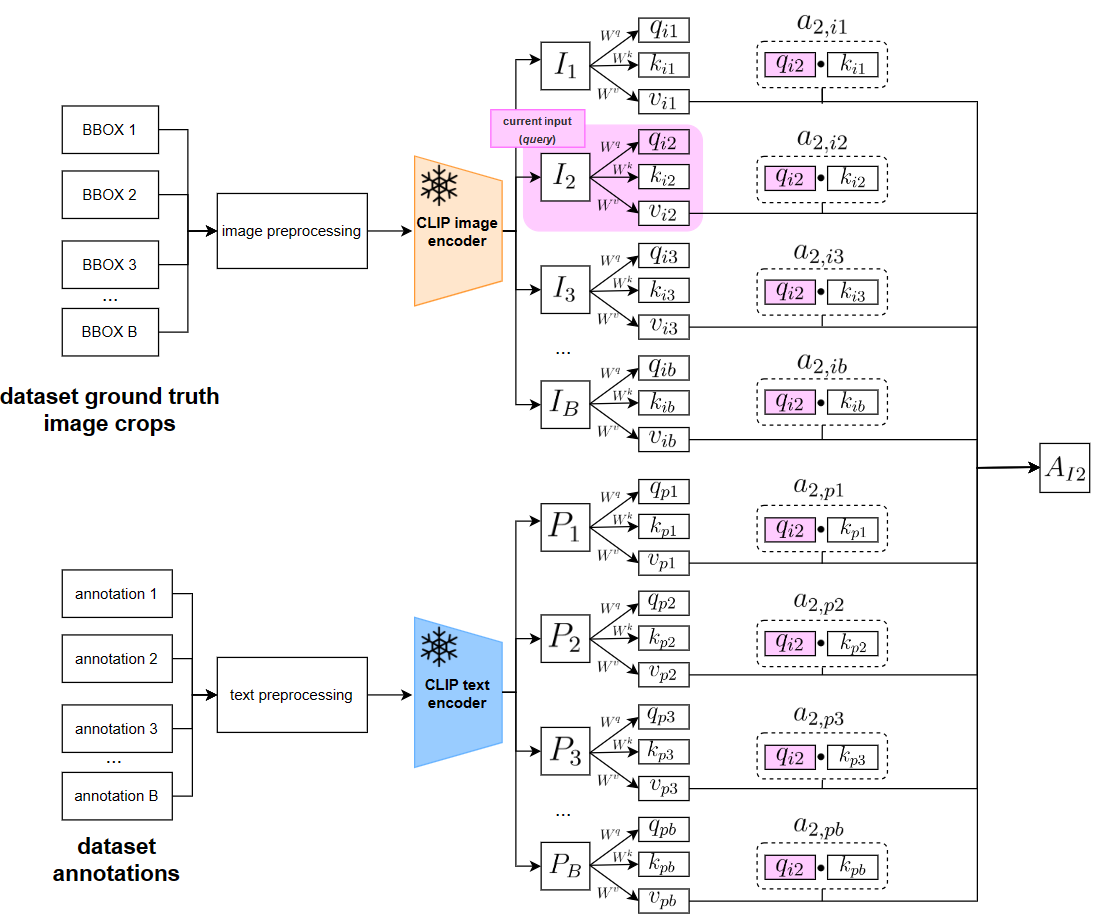

## Strategies to improve model generalization

### Hyperparameter tuning

In [ ]:
study: Study = optuna.create_study(
    storage=RDBStorage("sqlite:///assets/optuna.db"),
    study_name="flyp",
    load_if_exists=True
)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_timeline(study)

### Data augmentation and noise injection

## Conclusion and further research directions

todo: riflettere se abbiamo in mente come si potrebbe risolvere destra, sinistra, centro. Cosa che di fatto non abbiamo ancora risolto.

## References

[[1]](https://www.cs.utexas.edu/users/ai-lab/downloadPublication.php?filename=http://www.cs.utexas.edu/users/ml/papers/thomason.robonlp17.pdf&pubid=127642)  Jesse Thomason, Jivko Sinapov, and Raymond Mooney,
"Guiding interaction behaviors for multi-modal grounded language learning," in Proceedings of the First Workshop on Language Grounding for Robotics, 2017

[[2]](https://arxiv.org/abs/2103.00020) Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, et al. Learning transferable visual models from natural language supervision. In International conference on machine learning, pages 8748-8763. PMLR, 2021.

[[3]](https://arxiv.org/abs/1608.00272) Licheng Yu, Patrick Poirson, Shan Yang, Alexander C Berg, and Tamara L Berg. Modeling context in referring expressions. In Computer Vision-ECCV 2016: 14th European Conference, Amsterdam, The Netherlands, October 11-14, 2016, Proceedings, Part II 14, pages 69-85. Springer, 2016.


[[4]](https://arxiv.org/abs/2007.09554) Yanyuan Qiao and Chaorui Deng and Qi Wu. Referring Expression Comprehension: A Survey of Methods and Datasets. Year 2020.

[[5]](https://arxiv.org/abs/2212.00638) Sachin Goyal and Ananya Kumar and Sankalp Garg and Zico Kolter and Aditi Raghunathan. Finetune like you pretrain: Improved finetuning of zero-shot vision models. Year 2022.

[[6]](https://ieeexplore.ieee.org/document/8845685) S. Qiu, Y. Zhao, J. Jiao, Y. Wei, and S. Wei, "Referring image segmentation by generative adversarial learning", IEEE Trans. Multimedia. Year 2020.

[[7]](https://arxiv.org/abs/1505.00468) S. Antol, A. Agrawal, J. Lu, M. Mitchell, D. Batra, C. Lawrence Zitnick,
and D. Parikh, "Vqa: Visual question answering", in Proc. IEEE Int.
Conf. Comput. Vis. Year 2015.

[[8]](https://ieeexplore.ieee.org/document/9422035) Q. Wu, D. Teney, P. Wang, C. Shen, A. Dick, and A. van den Hengel, "Visual question answering: A survey of methods and datasets" Comput.
Vis. Image Underst. Year 2017.

[[9]](https://arxiv.org/abs/1904.05548) Z. Zheng, W. Wang, S. Qi, and S. Zhu, "Reasoning visual dialogs with structural and partial observations" in Proc. IEEE Conf. Comput. Vis.
Pattern Recognit. Year 2019.

[[10]](https://arxiv.org/abs/1809.01816) S. Kottur, J. M. F. Moura, D. Parikh, D. Batra, and M. Rohrbach, "Visual coreference resolution in visual dialog using neural module networks",
in Proc. Eur. Conf. Comput. Vis. Year 2018.

[[11]](https://arxiv.org/abs/1511.02283) J. Mao, J. Huang, A. Toshev, O. Camburu, A. L. Yuille, and K. Murphy, "Generation and comprehension of unambiguous object descriptions", in
Proc. IEEE Conf. Comput. Vis. Pattern Recognit. Year 2016.

[[12]](https://arxiv.org/abs/2202.10054) Ananya Kumar, Aditi Raghunathan, Robbie Matthew Jones, Tengyu Ma, and Percy Liang. "Fine-tuning can distort
pretrained features and underperform out-of-distribution". In International Conference on Learning Representations
(ICLR). Year 2022.

[[13]](https://arxiv.org/abs/2109.01903) Mitchell Wortsman, Gabriel Ilharco, Mike Li, Jong Wook Kim, Hannaneh Hajishirzi, Ali Farhadi, Hongseok
Namkoong, and Ludwig Schmidt. Robust fine-tuning of zero-shot models.CoRR. Year 2021.

[[14]](https://arxiv.org/abs/1803.01534) Shu Liu, Lu Qi, Haifang Qin, Jianping Shi, and Jiaya Jia. Path aggregation network for instance segmentation. In Proceedings of the IEEE conference on computer vision and pattern recognition. Year 2018.

[[15]](https://arxiv.org/abs/2104.11892) Syed Sahil Abbas Zaidi and Mohammad Samar Ansari and Asra Aslam and Nadia Kanwal and Mamoona Asghar and Brian Lee. A Survey of Modern Deep Learning based Object Detection Models. Year 2021.

[[16]](https://paperswithcode.com/task/object-detection) paperswithcode.com list of state of the art Object Detection algorithms. Last visited on 28th August 2023.

[[17]](https://arxiv.org/abs/1506.02640) Joseph Redmon and Santosh Divvala and Ross Girshick and Ali Farhadi. You Only Look Once: Unified, Real-Time Object Detection. Year 2015.

[[18]](https://arxiv.org/abs/2005.12872) Nicolas Carion and Francisco Massa and Gabriel Synnaeve and Nicolas Usunier and Alexander Kirillov and Sergey Zagoruyko. End-to-End Object Detection with Transformers. Year 2020.

[[19]](https://arxiv.org/abs/2109.01903) Mitchell Wortsman and Gabriel Ilharco and Jong Wook Kim and Mike Li and Simon Kornblith and Rebecca Roelofs and Raphael Gontijo-Lopes and Hannaneh Hajishirzi and Ali Farhadi and Hongseok Namkoong and Ludwig Schmidt. Robust fine-tuning of zero-shot models. Year 2021.

[[20]](https://arxiv.org/abs/2308.12919) Jian Liang and Lijun Sheng and Zhengbo Wang and Ran He and Tieniu Tan. Towards Realistic Unsupervised Fine-tuning with CLIP. Year 2023.

[[21]](https://arxiv.org/abs/2212.03640) Hanoona Rasheed and Muhammad Uzair Khattak and Muhammad Maaz and Salman Khan and Fahad Shahbaz Khan. Fine-tuned CLIP Models are Efficient Video Learners Year 2022.

[[22]](https://arxiv.org/abs/2007.03051) Lasse F. Wolff Anthony and Benjamin Kanding and Raghavendra Selvan. Carbontracker: Tracking and Predicting the Carbon Footprint of Training Deep Learning Models. Year 2020.

[[23]](https://arxiv.org/abs/2101.06983) Luyu Gao and Yunyi Zhang and Jiawei Han and Jamie Callan. Scaling Deep Contrastive Learning Batch Size under Memory Limited Setup. Year 2021.

[[24]](https://arxiv.org/abs/1706.03762) Ashish Vaswani and Noam Shazeer and Niki Parmar and Jakob Uszkoreit and Llion Jones and Aidan N. Gomez and Lukasz Kaiser and Illia Polosukhin. Attention Is All You Need. Year 2017.